In [223]:
import cv2
import numpy as np
from datetime import datetime
import time
import urllib.request
import matplotlib.pyplot as plt

### Notes
1. 刻度盘是否从0开始 ，该点为0时为5度 ang_val_convert是否shift5
2. cv2.HoughCircles中min,max 参数的设定会有影响
3. cv2.HoughLinesP中minLineLength的设定之前为65,会捕捉的noise 目前设定radius*.5
4. final_line的选择之前设定选后两个digits， 改为选择距离circle原点较远的位置
5. 象限逻辑做了调整

In [604]:
def avg_circles(circle, n):
    avg_x = 0
    avg_y = 0
    avg_r = 0
    for cir in range(n):
        avg_x += circle[0][cir][0]
        avg_y += circle[0][cir][1]
        avg_r += circle[0][cir][2]
    avg_x = int(avg_x / n)
    avg_y = int(avg_y / n)
    avg_r = int(avg_r / n)
    return avg_x, avg_y, avg_r


def ang_val_convert(deg):
    # 43 deg = 0
    # 312 deg = 100
#     value = 17200/269-(400*deg)/269-400#
    range_max=400
    value = (range_max*(deg-43))/269#-5#刻度盘不是从0 开始
    if value < 0:
        return 0
    elif value > range_max:
        return range_max
    return value


def avg_lines(line, n):
    avg_x1 = 0
    avg_y1 = 0
    avg_x2 = 0
    avg_y2 = 0
    for i in range(n):
        avg_x1 += line[i][0][0]
        avg_y1 += line[i][0][1]
        avg_x2 += line[i][0][2]
        avg_y2 += line[i][0][3]
    avg_x1 = int(avg_x1 / n)
    avg_y1 = int(avg_y1 / n)
    avg_x2 = int(avg_x2 / n)
    avg_y2 = int(avg_y2 / n)
    return [avg_x1, avg_y1, avg_x2, avg_y2]


def is_line_inside_circle(x0, y0, r0, x1, y1, x2, y2):
    temp = (x0 - x1)**2 + (y0 - y1)**2
    if temp <= r0**2:
        temp = (x0 - x2)**2 + (y0 - y2)**2
        if temp <= r0**2:
            return True
        return False
    return False

Image Captured.
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1706
648 900 570


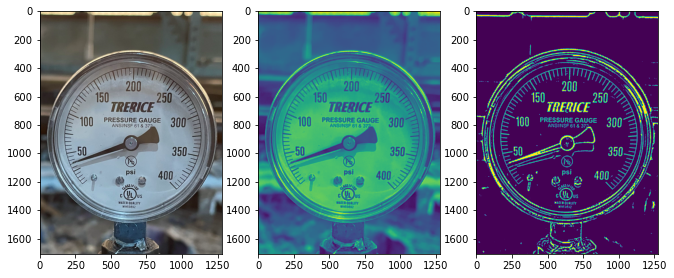

In [596]:
frame = cv2.imread('test.png')
plt.figure(figsize=(15,5))
plt.subplot(141),plt.imshow(frame)
print('Image Captured.')
grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
grayFrame = cv2.GaussianBlur(grayFrame, (7, 7), None)
# grayFrame = cv2.Canny(grayFrame, 50, 200, None, 3)
plt.subplot(142),plt.imshow(grayFrame)
adaptiveTresh = cv2.adaptiveThreshold(grayFrame, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 47, 7)
kernel = np.ones((3, 3), np.uint8)
print(adaptiveTresh)
erodeFrame = cv2.erode(adaptiveTresh, kernel, iterations=1)
plt.subplot(143),plt.imshow(erodeFrame)
rows = erodeFrame.shape[0]
print(rows)
circles = cv2.HoughCircles(erodeFrame, cv2.HOUGH_GRADIENT, 1, minDist=rows / 8, param1=150, param2=70, minRadius=frame.shape[1]//3,
                           maxRadius=frame.shape[1]//2)
try:
    a, b, c = circles.shape
    centreX, centreY, radius = avg_circles(circles, b)
except:
    a, b, c = [0, 0, 0]
    centreX, centreY, radius = [0, 0, 0]##
    print("No circle detected")
lines = cv2.HoughLinesP(erodeFrame, rho=1, theta=np.pi / 180, threshold=200, minLineLength=radius*.5)#65

print(centreX,centreY,radius)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7fe4525d5190>)

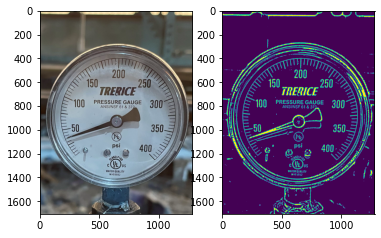

In [597]:
plt.subplot(121),plt.imshow(frame)
cv2.circle(frame, (centreX, centreY), radius, (255, 0, 0), 8)

# cv2.circle(frame, (800, 800), 450, (255, 0, 0), 8)
# cv2.circle(frame, (centreX, centreY), 3, (0, 255, 255),8)
cv2.HoughLinesP(erodeFrame, rho=1, theta=np.pi / 180, threshold=200, minLineLength=radius*0.6)
plt.subplot(122),plt.imshow(erodeFrame)


In [598]:
def pointer_arrow(x1, y1, x2, y2,centreX, centreY):
    point_1=np.array([x1, y1])
    point_2=np.array([x2, y2])
    centriod=np.array([centreX, centreY])
    dist1=np.sqrt(np.sum(np.square(point_1 - centriod)))
    dist2=np.sqrt(np.sum(np.square(point_2 - centriod)))
#     print(dist1,dist2)
    return([x1,y1] if dist1>dist2 else [x2,y2])

In [599]:
pointer_arrow(final_line[0],final_line[1],final_line[2],final_line[3],centreX, centreY)

[250, 1061]

In [600]:
good_lines = []

try:
    for t in lines:
        # frame = cv2.line(frame, (t[0][0], t[0][1]), (t[0][2], t[0][3]), (0, 0, 255), 2, None)
        if is_line_inside_circle(centreX, centreY, radius, t[0][0], t[0][1], t[0][2], t[0][3]) is True:
            good_lines.append(t)
except:
    good_lines = []
if good_lines:
    final_line = avg_lines(good_lines, len(good_lines))#
    final_arrow=pointer_arrow(final_line[0],final_line[1],final_line[2],final_line[3],centreX, centreY)
    x1, y1,x2,y2 = centreX, centreY, final_arrow[0], final_arrow[1]# why [2][3]如果指针在另外一个方向 是否可以选距离圆心较远的点
    frame = cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 3, 8)
else:
    x1, y1, x2, y2 = [1, 0, 0, 0]

theta = np.arctan(abs(y1 - y2) / abs(x1 - x2))
theta = np.rad2deg(theta)


# if x2 >= x1 and y2 >= y1:  # 4th Quad
#     angle = 90 - theta
# elif x2 >= x1 and y2 <= y1:  # 1st Quad
#     angle = 90 + theta
# elif x2 <= x1 and y2 <= y1:  # 2nd Quad
#     angle = 270 - theta
# else:  # 3rd Quad
#     angle = 270 + theta
    
if x2 >= x1 and y2 <= y1:  # 1th Quad
    angle = 270 - theta
    print("1st")
elif x2 <= x1 and y2 <= y1:  # 2nd Quad
    angle = 90 + theta
    print("2nd")
elif x2 <= x1 and y2 >= y1:  # 3rd Quad
    angle = 90 -theta
    print("3rd")
else:  # 4th Quad
    angle = 270 + theta
    print("4th")
print(angle)
val = ang_val_convert(angle)
val = round(val, 3)

3rd
67.9755544362398


In [601]:
print("angle from 0 cel :{:.2f}\ntrue angle from 0 degree:{:.3f}\nread value:{:.3f}"
      .format(theta,angle,val))

angle from 0 cel :22.02
true angle from 0 degree:67.976
read value:32.138


648 900 250 1061


Text(0.5, 1.0, 'aggregate  lines')

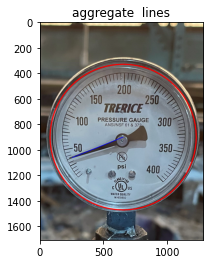

In [602]:
print(x1, y1, x2, y2 )
cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 3, 8)
plt.imshow(frame)
plt.imshow(frame);plt.title("aggregate  lines")

[[ 257 1059  596  929]]
[[ 230 1068  596  927]]
[[ 259 1060  596  930]]
[[ 230 1066  527  952]]
[[ 276 1055  604  955]]


Text(0.5, 1.0, 'all lines')

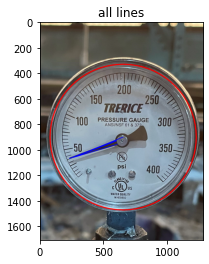

In [603]:
for i in good_lines:
    print(i)
    x1,y1,x2,y2=i[0]
    cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 3, 8)
plt.imshow(frame);plt.title("all lines")